## Dear Watson
NLP models have gotten stronger and more efficient: for the purposes of this dzataset, we're identified with two phrases, and we want to be able to classify them into three labels: entailment, neutral, and contradiction.


In [2]:
!pip install -q keras-nlp --upgrade
!pip install seaborn
!pip install transformers
!pip install sentencepiece

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import os


# Load the Contradictory, My Dear Watson dataset
Let's have a look at all the data files

The training set contains a premise, a hypothesis, a label (0 = entailment, 1 = neutral, 2 = contradiction), and the language of the text. For more information about what these mean and how the data is structured, check out the data page: https://www.kaggle.com/c/contradictory-my-dear-watson/data

In [7]:
DATA_DIR = '/kaggle/input/contradictory-my-dear-watson/'

RESULT_DICT = {
    0 : "entailment",
    1 : "neutral",
    2 : "contradiction"
}

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [8]:
df_train = pd.read_csv(DATA_DIR + "train.csv")
df_train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [ ]:
df_test = pd.read_csv(DATA_DIR + "test.csv")
df_test.head()

Let's look at some pairs of sentences.

In [ ]:
def display_pair_of_sentence(x):
    print( "Premise : " + x['premise'])
    print( "Hypothesis: " + x['hypothesis'])
    print( "Language: " + x['language'])
    print( "Label: " + str(x['label']))
    print()

df_train.head(10).apply(lambda x : display_pair_of_sentence(x), axis=1)

df_train.shape

# Explore the dataset

Let's look at the distribution of labels in the training set.

Text(0.5, 1.0, 'Distribution of labels in the training set')

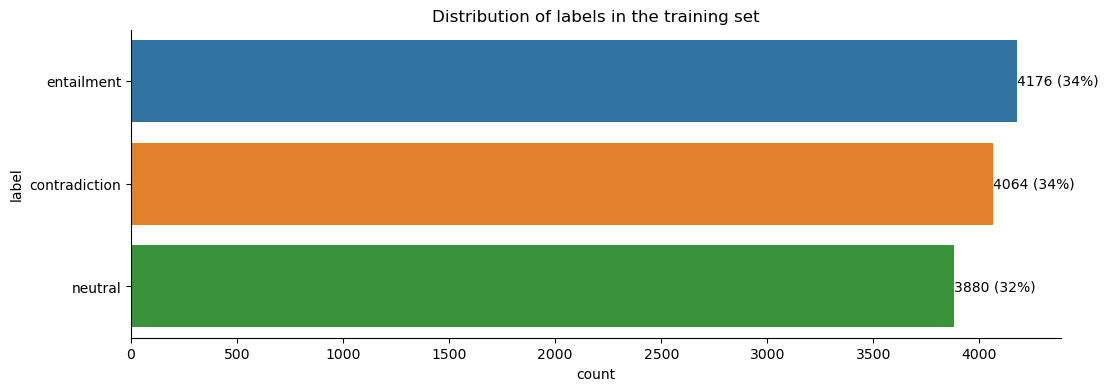

In [7]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 4))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=df_train, 
                   y="label",
                   order = df_train['label'].value_counts().index)

abs_values = df_train['label'].value_counts(ascending=False)
rel_values = df_train['label'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])

ax.set_title("Distribution of labels in the training set")

Text(0.5, 1.0, 'Distribution of languages in the training set')

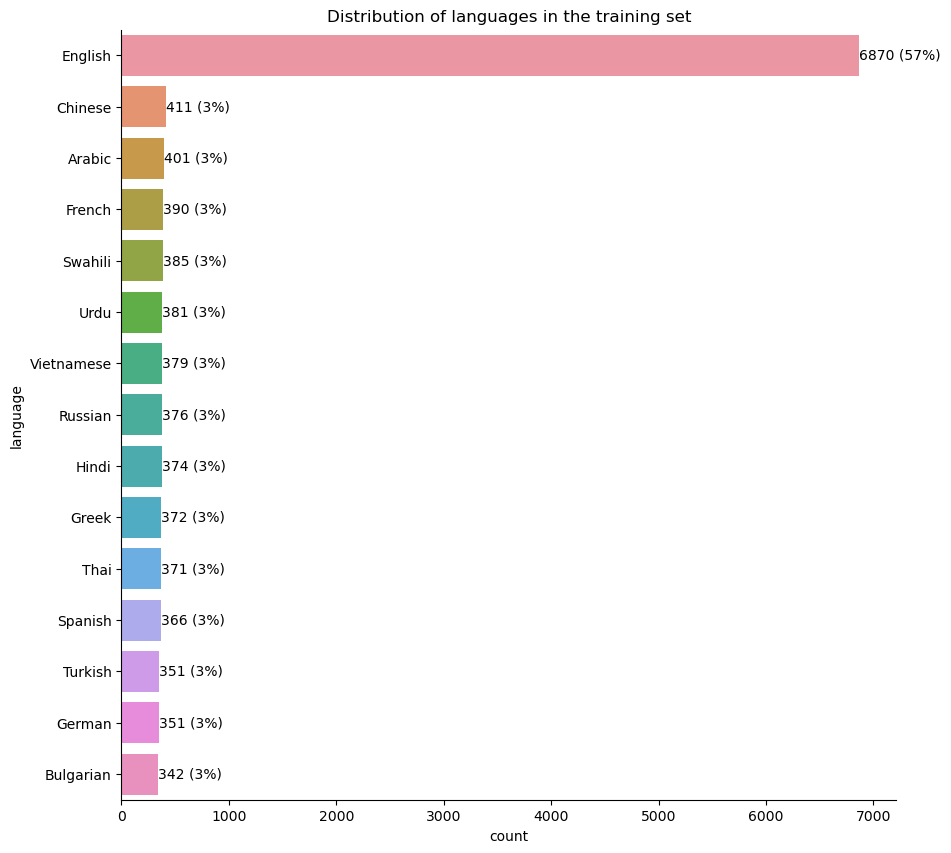

In [8]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=df_train, 
                   y="language",
                   order = df_train['language'].value_counts().index)

abs_values = df_train['language'].value_counts(ascending=False)
rel_values = df_train['language'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_title("Distribution of languages in the training set")

Let's look at the length of the sentences

In [9]:
df_train["premise_length"] = df_train["premise"].apply(lambda x : len(x))
df_train["hypothesis_length"] = df_train["hypothesis"].apply(lambda x : len(x))
df_train[["hypothesis_length", "premise_length"]].describe()

,hypothesis_length,premise_length
count,12120.000000,12120.000000
mean,53.892327,107.373185
std,25.302358,71.089954
min,4.000000,4.000000
25%,36.000000,55.000000
50%,51.000000,96.000000
75%,67.000000,146.000000
max,276.000000,967.000000


## XLM Roberta

XLM-RoBERTa is a multilingual language model developed by Facebook AI. It's based on the RoBERTa architecture, which itself is an optimized version of BERT. The "XLM" part stands for "Cross-lingual Language Model."


The main idea behind XLM-RoBERTa is to create a single model that can understand and process text in multiple languages. It was trained on a massive dataset of 2.5 TB of text from 100 different languages, without using any language-specific labels or data.

The model learns to understand the structure and patterns of various languages through unsupervised learning. It uses a masked language modeling objective, where it tries to predict randomly masked words in a sentence. This helps it learn the context and relationships between words across different languages.

In this notebook, we're going to use XLM-RoBERTa to train against our dataset, since it works for many different languages.

In [10]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def prepare_data(df, tokenizer, max_length=128):
    inputs = tokenizer(df['premise'].tolist(), df['hypothesis'].tolist(), 
                       padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    labels = torch.tensor(df['label'].tolist())
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['label'])

model_name = 'xlm-roberta-base'
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=3)

train_dataset = prepare_data(df_train, tokenizer)
val_dataset = prepare_data(df_val, tokenizer)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        progress_bar.set_postfix({'loss': loss.item()})
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
            
            outputs = model(**inputs)
            logits = outputs.logits
            
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(batch[2].cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    
    return accuracy, f1

def train_and_evaluate(model, train_loader, val_loader, lr, epochs, device):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    
    best_f1 = 0
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_accuracy, val_f1 = evaluate(model, val_loader, device)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Validation F1: {val_f1:.4f}")
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')
    
    return best_f1

learning_rates = [1e-5, 3e-5, 5e-5]
epochs_list = [3, 5]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_lr = None
best_epochs = None
best_overall_f1 = 0

for lr in learning_rates:
    for epochs in epochs_list:
        print(f"\nTraining with lr={lr}, epochs={epochs}")
        model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=3)
        f1 = train_and_evaluate(model, train_loader, val_loader, lr, epochs, device)
        
        if f1 > best_overall_f1:
            best_overall_f1 = f1
            best_lr = lr
            best_epochs = epochs

print(f"\nBest Hyperparameters: lr={best_lr}, epochs={best_epochs}")
print(f"Best F1 Score: {best_overall_f1:.4f}")

final_model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=3)
train_and_evaluate(final_model, train_loader, val_loader, best_lr, best_epochs, device)

final_model.load_state_dict(torch.load('best_model.pth'))
final_accuracy, final_f1 = evaluate(final_model, val_loader, device)

print(f"\nFinal Model Performance:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"F1 Score: {final_f1:.4f}")

Using device: cuda


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.o


Training with lr=1e-05, epochs=3


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.o

Epoch 1/3
Train Loss: 1.0978
Validation Accuracy: 0.3585
Validation F1: 0.2277


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.85it/s]


Epoch 2/3
Train Loss: 0.9580
Validation Accuracy: 0.6716
Validation F1: 0.6743


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.85it/s]


Epoch 3/3
Train Loss: 0.7188
Validation Accuracy: 0.7228
Validation F1: 0.7244

Training with lr=1e-05, epochs=5


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.o

Epoch 1/5
Train Loss: 1.1000
Validation Accuracy: 0.4026
Validation F1: 0.3161


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.85it/s]


Epoch 2/5
Train Loss: 1.0534
Validation Accuracy: 0.5685
Validation F1: 0.5383


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.84it/s]


Epoch 3/5
Train Loss: 0.8340
Validation Accuracy: 0.6654
Validation F1: 0.6659


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.86it/s]


Epoch 4/5
Train Loss: 0.6581
Validation Accuracy: 0.7005
Validation F1: 0.7008


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.84it/s]


Epoch 5/5
Train Loss: 0.5224
Validation Accuracy: 0.7166
Validation F1: 0.7178

Training with lr=3e-05, epochs=3


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.o

Epoch 1/3
Train Loss: 1.0957
Validation Accuracy: 0.4455
Validation F1: 0.3954


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.87it/s]


Epoch 2/3
Train Loss: 1.1010
Validation Accuracy: 0.3927
Validation F1: 0.3022


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.86it/s]


Epoch 3/3
Train Loss: 1.0836
Validation Accuracy: 0.4550
Validation F1: 0.3773

Training with lr=3e-05, epochs=5


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.o

Epoch 1/5
Train Loss: 1.0763
Validation Accuracy: 0.5710
Validation F1: 0.5656


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.86it/s]


Epoch 2/5
Train Loss: 0.8838
Validation Accuracy: 0.7005
Validation F1: 0.6995


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.85it/s]


Epoch 3/5
Train Loss: 0.6729
Validation Accuracy: 0.7191
Validation F1: 0.7181


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.86it/s]


Epoch 4/5
Train Loss: 0.4846
Validation Accuracy: 0.7046
Validation F1: 0.7039


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.86it/s]


Epoch 5/5
Train Loss: 0.3554
Validation Accuracy: 0.7054
Validation F1: 0.7072

Training with lr=5e-05, epochs=3


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.o

Epoch 1/3
Train Loss: 1.1036
Validation Accuracy: 0.3354
Validation F1: 0.1685


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.87it/s]


Epoch 2/3
Train Loss: 1.1038
Validation Accuracy: 0.3354
Validation F1: 0.1685


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.84it/s]


Epoch 3/3
Train Loss: 1.1025
Validation Accuracy: 0.3354
Validation F1: 0.1685

Training with lr=5e-05, epochs=5


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.o

Epoch 1/5
Train Loss: 1.1034
Validation Accuracy: 0.3354
Validation F1: 0.1685


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.85it/s]


Epoch 2/5
Train Loss: 1.1036
Validation Accuracy: 0.3354
Validation F1: 0.1685


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.87it/s]


Epoch 3/5
Train Loss: 1.1028
Validation Accuracy: 0.3354
Validation F1: 0.1685


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.86it/s]


Epoch 4/5
Train Loss: 1.1022
Validation Accuracy: 0.3445
Validation F1: 0.1765


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.86it/s]


Epoch 5/5
Train Loss: 1.1039
Validation Accuracy: 0.3354
Validation F1: 0.1685

Best Hyperparameters: lr=1e-05, epochs=3
Best F1 Score: 0.7244


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.o

Epoch 1/3
Train Loss: 1.0939
Validation Accuracy: 0.5260
Validation F1: 0.5126


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.87it/s]


Epoch 2/3
Train Loss: 0.8743
Validation Accuracy: 0.7133
Validation F1: 0.7132


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.87it/s]


Epoch 3/3
Train Loss: 0.6736
Validation Accuracy: 0.7285
Validation F1: 0.7286


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.85it/s]


Final Model Performance:
Accuracy: 0.7285
F1 Score: 0.7286


In [11]:
from transformers import XLMRobertaTokenizer
import torch
torch.cuda.empty_cache()
# Initialize the tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)

# Tokenize the inputs
inputs = tokenizer(
    list(df_test['premise']),
    list(df_test['hypothesis']),
    return_tensors='pt',
    truncation=True,
    padding=True,
    max_length=128
)

# Move the model to the GPU if available
device = torch.device("cpu")
final_model.to(device)

# Move the inputs to the correct device
inputs = {key: val.to(device) for key, val in inputs.items()}

# Put the model in evaluation mode
final_model.eval()

# Make predictions
with torch.no_grad():
    torch.cuda.empty_cache()
    outputs = final_model(**inputs)
    logits = outputs.logits
    

# Convert logits to predicted labels
predictions = torch.argmax(logits, dim=-1).cpu().numpy()


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

## Another strategy:

This strategy translates all non-English text to English, then uses a pre-trained English BERT model for natural language inference.
It uses one powerful English model instead of multiple language-specific ones, and BERT is good at understanding relationships between words and sentences.
The model itself is just BERT with an added layer to classify the relationship between two sentences (entailment, neutral, or contradiction).

In [9]:
!pip install googletrans

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
from tqdm.auto import tqdm
from googletrans import Translator

# 1. Translate non-English text
def translate_text(df):
    translator = Translator()
    
    def translate_if_needed(text, lang):
        if lang != 'en':
            try:
                return translator.translate(text, dest='en').text
            except:
                print(f"Translation failed for: {text}")
                return text
        return text

    tqdm.pandas()
    df['premise_en'] = df.progress_apply(lambda row: translate_if_needed(row['premise'], row['lang_abv']), axis=1)
    df['hypothesis_en'] = df.progress_apply(lambda row: translate_if_needed(row['hypothesis'], row['lang_abv']), axis=1)
    
    return df

# Translate the dataset
df_train = translate_text(df_train)

# 2. Data Preparation
def prepare_data(df, tokenizer, max_length=128):
    inputs = tokenizer(df['premise_en'].tolist(), df['hypothesis_en'].tolist(), 
                       padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    labels = torch.tensor(df['label'].tolist())
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

# 3. Split Data
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['label'])

# 4. Load Model and Tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

# 5. Prepare Datasets
train_dataset = prepare_data(df_train, tokenizer)
val_dataset = prepare_data(df_val, tokenizer)

# 6. Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# 7. Training Function
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    return total_loss / len(dataloader)

# 8. Evaluation Function
def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
            
            outputs = model(**inputs)
            logits = outputs.logits
            
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(batch[2].cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    
    return accuracy, f1

# 9. Training Loop with Hyperparameter Tuning
def train_and_evaluate(model, train_loader, val_loader, lr, epochs, device):
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    
    best_f1 = 0
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_accuracy, val_f1 = evaluate(model, val_loader, device)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Validation F1: {val_f1:.4f}")
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_model_bert.pth')
    
    return best_f1

# 10. Hyperparameter Tuning
learning_rates = [1e-5, 3e-5, 5e-5]
epochs_list = [3, 5]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_lr = None
best_epochs = None
best_overall_f1 = 0

for lr in learning_rates:
    for epochs in epochs_list:
        print(f"\nTraining with lr={lr}, epochs={epochs}")
        model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)
        f1 = train_and_evaluate(model, train_loader, val_loader, lr, epochs, device)
        
        if f1 > best_overall_f1:
            best_overall_f1 = f1
            best_lr = lr
            best_epochs = epochs

print(f"\nBest Hyperparameters: lr={best_lr}, epochs={best_epochs}")
print(f"Best F1 Score: {best_overall_f1:.4f}")

# 11. Final Model Training
final_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)
train_and_evaluate(final_model, train_loader, val_loader, best_lr, best_epochs, device)

# 12. Load Best Model and Final Evaluation
final_model.load_state_dict(torch.load('best_model_bert.pth'))
final_accuracy, final_f1 = evaluate(final_model, val_loader, device)

print(f"\nFinal Model Performance:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"F1 Score: {final_f1:.4f}")

  0%|          | 0/12120 [00:00<?, ?it/s]

Translation failed for: Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.
Translation failed for: ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้ายคลึงและความแตกต่างระหว่างผู้คนในด้านความปรารถนา ความเชื่อ และความรู้สึกได้
Translation failed for: Bir çiftlikte birisinin, ağıla kapatılmış bu öküzleri kesmeliyiz dediğini duyabilirsiniz bu muhtemelen şu anlama gelir, yüklenecek olanları ayırın.
Translation failed for: ریاست ہائے متحدہ امریکہ واپس آنے پر، ہج ایف بی آئی کے ایجنٹوں کے ذریعے ہوائی اڈے پر ملاقات کی، تحقیقات کی، اور اگلے دن وفاقی گرین جوری سے پہلے اسامہ بن لادن کی تحقیقات سے ملاقات کی.
Translation failed for: Через каждые сто градусов пятна краски меняют свой цвет, она может быть красной и изменить цвет на синий.
Translation failed for: Може да не сме имали всичко, което сме искали или сме видели, че други хора имат, но тя осигуряваше необходимите неща, от които се нуждаехме.
Tr

  0%|          | 0/12120 [00:00<?, ?it/s]

Translation failed for: J'essayais d'accomplir quelque chose.
Translation failed for: เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร
Translation failed for: Çiftlikte insanlar farklı terimler kullanırlar.
Translation failed for: ہیگ کی تفتیش ایف بی آئی اہلکاروں  کی طرف سے کی گئی
Translation failed for: Краска изменяется в соответствии с цветом.
Translation failed for: Имахме всичко, от което наистина се нуждаехме.
Translation failed for: Könnte das Interesse mehr als 20 sein?
Translation failed for: حاول أن تفهم الحبكة في البداية، إذا كنت تستطيع.
Translation failed for: 大人刚刚接受了我的意见，并且采取了相应的行动。
Translation failed for: मज़ौदी ने दावा किया कि वह योजना के अनुसार योजना के साथ चला गया।
Translation failed for: Watoto wangeweza kwenda kwa majirani zao nyumba.
Translation failed for: От меня скрыли множество деталей.
Translation failed for: Giọng của Chúa cảm thấy thật xa xôi và lạnh lẽo
Translation failed for: 27 La dificultad depende de las modificaciones.
Translation failed for: Οι κυβερνητ

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i


Training with lr=1e-05, epochs=3


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 1/3
Train Loss: 1.0857
Validation Accuracy: 0.4645
Validation F1: 0.4368


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 2/3
Train Loss: 0.9528
Validation Accuracy: 0.5495
Validation F1: 0.5502


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 3/3
Train Loss: 0.7974
Validation Accuracy: 0.5734
Validation F1: 0.5731

Training with lr=1e-05, epochs=5


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 1/5
Train Loss: 1.0860
Validation Accuracy: 0.4876
Validation F1: 0.4774


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 2/5
Train Loss: 0.9573
Validation Accuracy: 0.5569
Validation F1: 0.5576


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 3/5
Train Loss: 0.8215
Validation Accuracy: 0.5652
Validation F1: 0.5639


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 4/5
Train Loss: 0.6793
Validation Accuracy: 0.5887
Validation F1: 0.5889


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 5/5
Train Loss: 0.5540
Validation Accuracy: 0.5924
Validation F1: 0.5896

Training with lr=3e-05, epochs=3


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 1/3
Train Loss: 1.0612
Validation Accuracy: 0.4975
Validation F1: 0.4740


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 2/3
Train Loss: 0.8863
Validation Accuracy: 0.5421
Validation F1: 0.5241


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 3/3
Train Loss: 0.6626
Validation Accuracy: 0.5668
Validation F1: 0.5664

Training with lr=3e-05, epochs=5


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 1/5
Train Loss: 1.0335
Validation Accuracy: 0.5441
Validation F1: 0.5337


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 2/5
Train Loss: 0.8283
Validation Accuracy: 0.5908
Validation F1: 0.5880


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 3/5
Train Loss: 0.6010
Validation Accuracy: 0.6007
Validation F1: 0.5961


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 4/5
Train Loss: 0.4492
Validation Accuracy: 0.5883
Validation F1: 0.5865


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 5/5
Train Loss: 0.3527
Validation Accuracy: 0.5804
Validation F1: 0.5736

Training with lr=5e-05, epochs=3


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 1/3
Train Loss: 1.0335
Validation Accuracy: 0.4983
Validation F1: 0.4799


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 2/3
Train Loss: 0.8446
Validation Accuracy: 0.5611
Validation F1: 0.5537


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 3/3
Train Loss: 0.6217
Validation Accuracy: 0.5730
Validation F1: 0.5683

Training with lr=5e-05, epochs=5


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 1/5
Train Loss: 1.0457
Validation Accuracy: 0.5297
Validation F1: 0.5094


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 2/5
Train Loss: 0.8471
Validation Accuracy: 0.5561
Validation F1: 0.5552


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 3/5
Train Loss: 0.6308
Validation Accuracy: 0.5611
Validation F1: 0.5624


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 4/5
Train Loss: 0.4626
Validation Accuracy: 0.5623
Validation F1: 0.5616


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 5/5
Train Loss: 0.3646
Validation Accuracy: 0.5734
Validation F1: 0.5705

Best Hyperparameters: lr=3e-05, epochs=5
Best F1 Score: 0.5961


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 1/5
Train Loss: 1.0429
Validation Accuracy: 0.5078
Validation F1: 0.4992


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 2/5
Train Loss: 0.8492
Validation Accuracy: 0.5705
Validation F1: 0.5702


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 3/5
Train Loss: 0.6270
Validation Accuracy: 0.5833
Validation F1: 0.5839


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 4/5
Train Loss: 0.4629
Validation Accuracy: 0.5870
Validation F1: 0.5855


Training:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 5/5
Train Loss: 0.3610
Validation Accuracy: 0.5776
Validation F1: 0.5775


Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]


Final Model Performance:
Accuracy: 0.5870
F1 Score: 0.5855


## Model analysis
We see that the Roberta model beats the BERT + translation model. This is most likely because the translations either did not work or were faulty, since the google api I was using was free. The Roberta model got a result of 73% which beats out the 58% that we got from our bert + translation model. 

## Future steps
It would be interesting to use a better translation model, and maybe the EDA and pre processing that were used could also be applied to the pre-translated text, so we could remove language specific stop words.